In [2]:
# Dependencies and Setup
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

# Hide warning messages in notebook
# this is nice.
import warnings
warnings.filterwarnings('ignore')

In [3]:
# reading in the csvs to create dataframes
mouse_df = pd.read_csv(os.path.join("..","data","mouse_drug_data.csv"))
clinical_df = pd.read_csv(os.path.join("..","data","clinicaltrial_data.csv"))
# Combine the data into a single dataset
combined_df = pd.merge(mouse_df, clinical_df, on="Mouse ID", how="outer")
# only looking at 4 drugs
combined_df = combined_df.loc[combined_df["Drug"].isin(("Capomulin", \
                                                        "Infubinol", "Ketapril", "Placebo")),:]
# Display the data table for preview
combined_df.head()

,Mouse ID,Drug,Timepoint,Tumor Volume (mm3),Metastatic Sites
393,q119,Ketapril,0,45.000000,0
394,q119,Ketapril,5,47.864440,0
395,q119,Ketapril,10,51.236606,0
396,n923,Ketapril,0,45.000000,0
397,n923,Ketapril,5,45.824881,0


In [4]:
combined_df.shape

(777, 5)

In [5]:
# checking for null values
combined_df.isnull().any()

Mouse ID              False
Drug                  False
Timepoint             False
Tumor Volume (mm3)    False
Metastatic Sites      False
dtype: bool

In [17]:
# cleaning up the data a bit. 
# first getting the number of observations of each mouse
mouse_data_points = combined_df["Mouse ID"].value_counts()
# then getting a list of each of the mice for which there is more than one and fewer than 11 observations
one_to_ten_mice_obs = [mouse for mouse in mouse_data_points.index if (mouse_data_points[mouse] > 1 \
                                                                      and mouse_data_points[mouse] < 11)]
# setting the df to only look at those records where there is more than one mouse to exclude those which
# died immediately. Perhaps the scientists would want to remove mice with different criteria, in which case
# the condition in the list comprehension would be changed accordingly.
combined_df = combined_df.loc[(combined_df["Mouse ID"].isin(one_to_ten_mice_obs)),:]
combined_df.shape
# 3 records removed

(774, 5)

In [18]:
# in the full data set, mouse g989 had 26 observations, 13 each for 2 different drugs, with multiple
# observations at several timepoints. I would assume that this was a labeling error, and that g989 was
# was actually 4 different mice. If this analysis included the whole dataset, I would exclude those
# observations.

# first, group by Mouse ID.
mice_group = combined_df.groupby(["Mouse ID"])

# building a list of mice that have multiple associated drugs
multi_drug_mice = []
for mouse in np.unique(combined_df["Mouse ID"].to_numpy()):
    if len(np.unique(mice_group.get_group(mouse)["Drug"].to_numpy())) > 1:
        multi_drug_mice.append(mouse)

# forunately, this list is empty, so the analysis can begin in earnest
multi_drug_mice

[]

## Tumor Response to Treatment

In [21]:
# Store the Mean Tumor Volume Data Grouped by Drug and Timepoint. GroupBy summaraies are already DataFrames
mean_tumor_volume = combined_df.groupby(["Drug", "Timepoint"]).mean()["Tumor Volume (mm3)"]
mean_tumor_volume = mean_tumor_volume.reset_index()
# Preview DataFrame
mean_tumor_volume.head()

pandas.core.frame.DataFrame

In [22]:
# Store the Standard Error of Tumor Volumes Grouped by Drug and Timepoint
sem_tumor_volume = combined_df.groupby(["Drug", "Timepoint"]).sem()["Tumor Volume (mm3)"].reset_index()
# Preview DataFrame
sem_tumor_volume.head()

,Drug,Timepoint,Tumor Volume (mm3)
0,Capomulin,0,0.000000
1,Capomulin,5,0.448593
2,Capomulin,10,0.702684
3,Capomulin,15,0.838617
4,Capomulin,20,0.909731


In [24]:
# Minor Data Munging to Re-Format the Data Frames
mean_tumor_volume_rf = pd.pivot_table(mean_tumor_volume, values="Tumor Volume (mm3)",index="Timepoint",
                                      columns="Drug")
sem_tumor_volume_rf = pd.pivot_table(sem_tumor_volume, values="Tumor Volume (mm3)",index="Timepoint",
                                      columns="Drug")
# Preview that Reformatting worked
mean_tumor_volume_rf.head()

Drug,Capomulin,Infubinol,Ketapril,Placebo
Timepoint,,,,
0,45.000000,45.000000,45.000000,45.000000
5,44.266086,47.062001,47.389175,47.125589
10,43.084291,49.403909,49.582269,49.423329
15,42.064317,51.296397,52.399974,51.359742
20,40.716325,53.197691,54.920935,54.364417


In [25]:
sem_tumor_volume_rf.head()

Drug,Capomulin,Infubinol,Ketapril,Placebo
Timepoint,,,,
0,0.000000,0.000000,0.000000,0.000000
5,0.448593,0.235102,0.264819,0.218091
10,0.702684,0.282346,0.357421,0.402064
15,0.838617,0.357705,0.580268,0.614461
20,0.909731,0.476210,0.726484,0.839609


In [26]:
# storing a colors dictionary
colors = {"Capomulin":"blue","Infubinol":"purple","Ketapril":"red","Placebo":"grey"}


Text(0, -50, 'Only Capomulin is effective in reducing tumor volume')

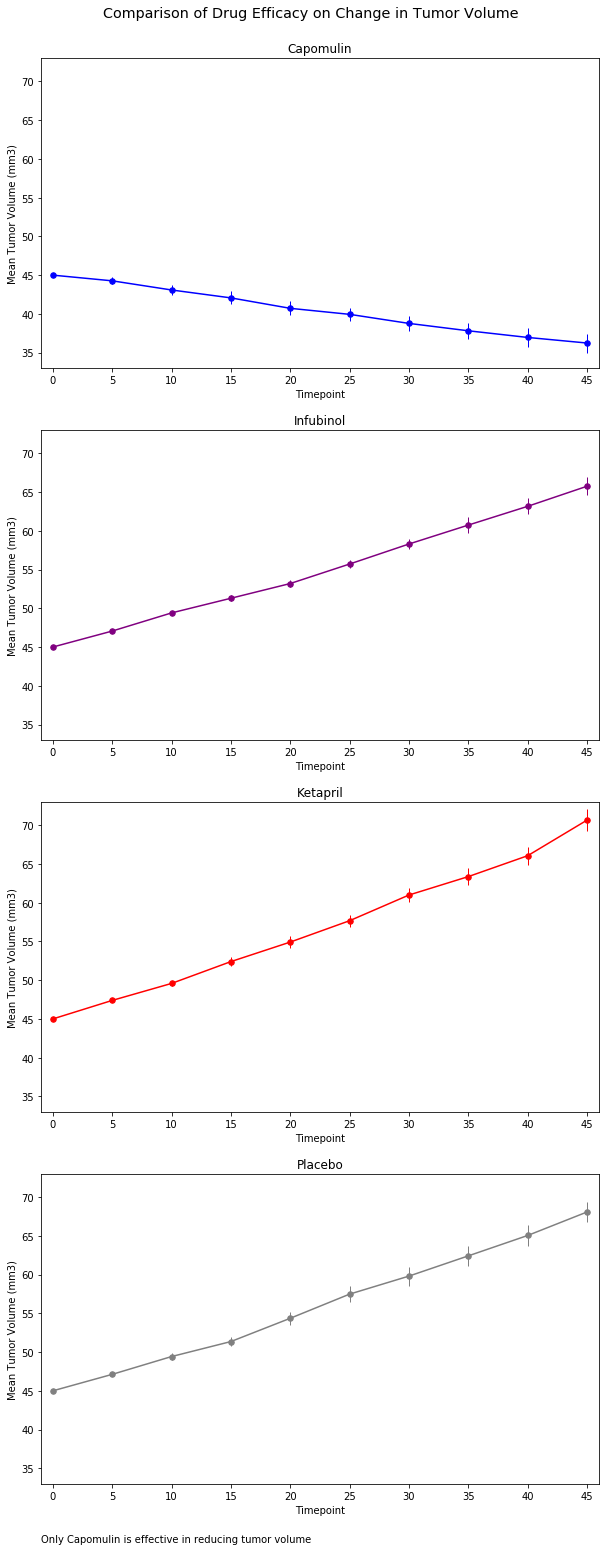

In [30]:
# Generate the Plot (with Error Bars)
# using subplots because having every drug errorbar on one graph is too crowded
# sharing x & y axes makes visual comparison easier
# plt.title
fig, (p1,p2,p3,p4) = plt.subplots(4, sharey=True,figsize=(10,24))
x_ticks = mean_tumor_volume_rf.index
# p1.set_xlim(min(x_ticks)*0.95, max(x_ticks)*1.05)
# p1.set_xticks(x_ticks)
p1.set_ylim(33,73)
p1.set_yticks(np.arange(35,71,5))

counter = 0
for p in (p1,p2,p3,p4):
    # get the drug name from the list of columns to easily get series
    drug = mean_tumor_volume_rf.columns[counter]
    p.scatter(x_ticks, mean_tumor_volume_rf[drug], c=colors[drug], s=30, label=drug)
    p.errorbar(x_ticks, mean_tumor_volume_rf[drug], sem_tumor_volume_rf[drug], c=colors[drug], 
               label=drug, elinewidth = 1)
    p.title.set_text(drug)
    p.set_xticks(x_ticks)
    p.set_xlim(min(x_ticks)-1, max(x_ticks)+1)
    p.set_xlabel("Timepoint")
    p.set_ylabel("Mean Tumor Volume (mm3)")
    counter += 1

# plt.figure(figsize = (12,14))
# for drug in mean_tumor_volume_rf:
#     plt.scatter(mean_tumor_volume_rf.index, mean_tumor_volume_rf[drug], c = colors[drug], s=16, \
#                 label=drug)
#     plt.errorbar(mean_tumor_volume_rf.index, mean_tumor_volume_rf[drug], sem_tumor_volume_rf[drug], 
#                  color= colors[drug], fmt='')

# plt.legend(loc="best")
# plt.ylabel("Mean Tumor Volume (mm3)")
# plt.xlabel("Timepoint")
# plt.tight_layout()
fig.suptitle("Comparison of Drug Efficacy on Change in Tumor Volume", fontsize="x-large")
fig.subplots_adjust(top=.95)
plt.annotate('Only Capomulin is effective in reducing tumor volume', 
             (0,0), (0, -50), xycoords='axes fraction', textcoords='offset points', va='top')
# plt.ylabel("")


In [29]:
# Save the Figure
fig.savefig("../Images/Comparison of Drug Efficacy on Change in Tumor Volume.png")

# Show the Figure
plt.show()

![Tumor Response to Treatment](../Images/treatment.png)

## Metastatic Response to Treatment

In [31]:
# Store the Mean Met. Site Data Grouped by Drug and Timepoint 
mean_met_sites = combined_df.groupby(["Drug", "Timepoint"]).mean()["Metastatic Sites"].reset_index()
# Preview DataFrame
mean_met_sites.head()

,Drug,Timepoint,Metastatic Sites
0,Capomulin,0,0.000000
1,Capomulin,5,0.160000
2,Capomulin,10,0.320000
3,Capomulin,15,0.375000
4,Capomulin,20,0.652174


In [32]:
# Store the Standard Error associated with Met. Sites Grouped by Drug and Timepoint 
sem_met_sites = combined_df.groupby(["Drug", "Timepoint"]).sem()["Metastatic Sites"].reset_index()
# Preview DataFrame
sem_met_sites.head()

,Drug,Timepoint,Metastatic Sites
0,Capomulin,0,0.000000
1,Capomulin,5,0.074833
2,Capomulin,10,0.125433
3,Capomulin,15,0.132048
4,Capomulin,20,0.161621


In [33]:
# Minor Data Munging to Re-Format the Data Frames

# Preview that Reformatting worked
mean_met_sites_rf = pd.pivot_table(mean_met_sites, values="Metastatic Sites",index="Timepoint",
                                      columns="Drug")
sem_met_sites_rf = pd.pivot_table(sem_met_sites, values="Metastatic Sites",index="Timepoint",
                                      columns="Drug")
mean_met_sites_rf.head()


Drug,Capomulin,Infubinol,Ketapril,Placebo
Timepoint,,,,
0,0.000000,0.000000,0.000000,0.000000
5,0.160000,0.280000,0.304348,0.375000
10,0.320000,0.666667,0.590909,0.833333
15,0.375000,0.904762,0.842105,1.250000
20,0.652174,1.050000,1.210526,1.526316


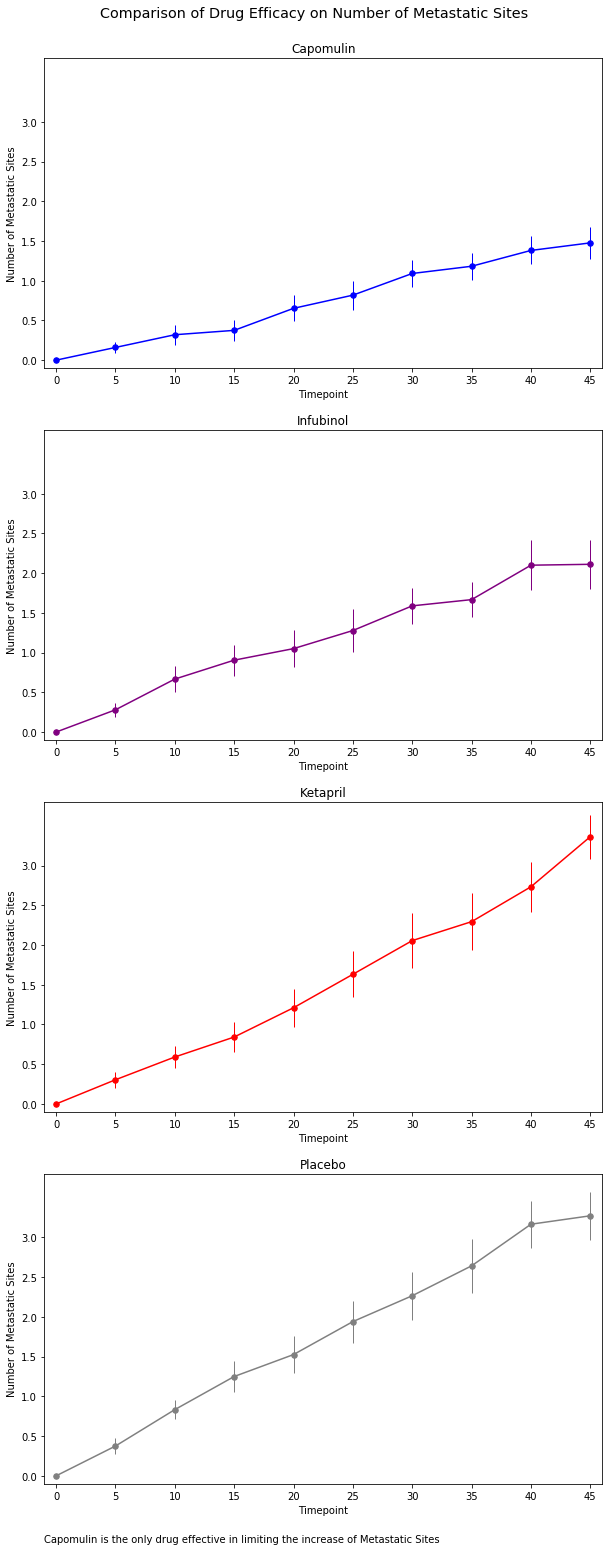

In [46]:
# Generate the Plot (with Error Bars)
# reusing variable names
fig, (p1,p2,p3,p4) = plt.subplots(4, sharey=True,figsize=(10,24))
x_ticks = mean_tumor_volume_rf.index
# p1.set_xlim(min(x_ticks)*0.95, max(x_ticks)*1.05)
# p1.set_xticks(x_ticks)
p1.set_ylim(-.1,3.8)
p1.set_yticks(np.arange(0,3.5,.5))

counter = 0
for p in (p1,p2,p3,p4):
    # get the drug name from the list of columns for easy reference
    drug = mean_tumor_volume_rf.columns[counter]
    p.scatter(x_ticks, mean_met_sites_rf[drug], c=colors[drug], s=30, label=drug)
    p.errorbar(x_ticks, mean_met_sites_rf[drug], sem_met_sites_rf[drug], c=colors[drug], 
               label=drug, elinewidth = 1)
    p.title.set_text(drug)
    p.set_xticks(x_ticks)
    p.set_xlim(min(x_ticks)-1, max(x_ticks)+1)
    p.set_xlabel("Timepoint")
    p.set_ylabel("Number of Metastatic Sites")
    counter += 1
    
fig.suptitle("Comparison of Drug Efficacy on Number of Metastatic Sites", fontsize="x-large")
fig.subplots_adjust(top=.95)
plt.annotate('Capomulin is the only drug effective in limiting the increase of Metastatic Sites', 
             (0,0), (0, -50), xycoords='axes fraction', textcoords='offset points', va='top')
# Save the Figure
fig.savefig("../Images/Comparison of Drug Efficacy on Number of Metastatic Sites.png")
# Show the Figure
plt.show()

![Metastatic Spread During Treatment](../Images/spread.png)

## Survival Rates

In [37]:
mouse_counts = combined_df.groupby(["Drug", "Timepoint"]).count().reset_index()


In [38]:
# Minor Data Munging to Re-Format the Data Frames
mouse_counts_rf = pd.pivot_table(mouse_counts, values="Mouse ID",index="Timepoint",
                                      columns="Drug")
# Preview the Data Frame
mouse_counts_rf

Drug,Capomulin,Infubinol,Ketapril,Placebo
Timepoint,,,,
0,25,25,23,24
5,25,25,23,24
10,25,21,22,24
15,24,21,19,20
20,23,20,19,19
25,22,18,19,17
30,22,17,18,15
35,22,12,17,14
40,21,10,15,12


Drug,Capomulin,Ceftamin,Infubinol,Ketapril,Naftisol,Placebo,Propriva,Ramicane,Stelasyn,Zoniferol
Timepoint,,,,,,,,,,
0,25,25,25,25,25,25,26,25,26,25
5,25,21,25,23,23,24,25,25,25,24
10,25,20,21,22,21,24,23,24,23,22
15,24,19,21,19,21,20,17,24,23,21
20,23,18,20,19,20,19,17,23,21,17


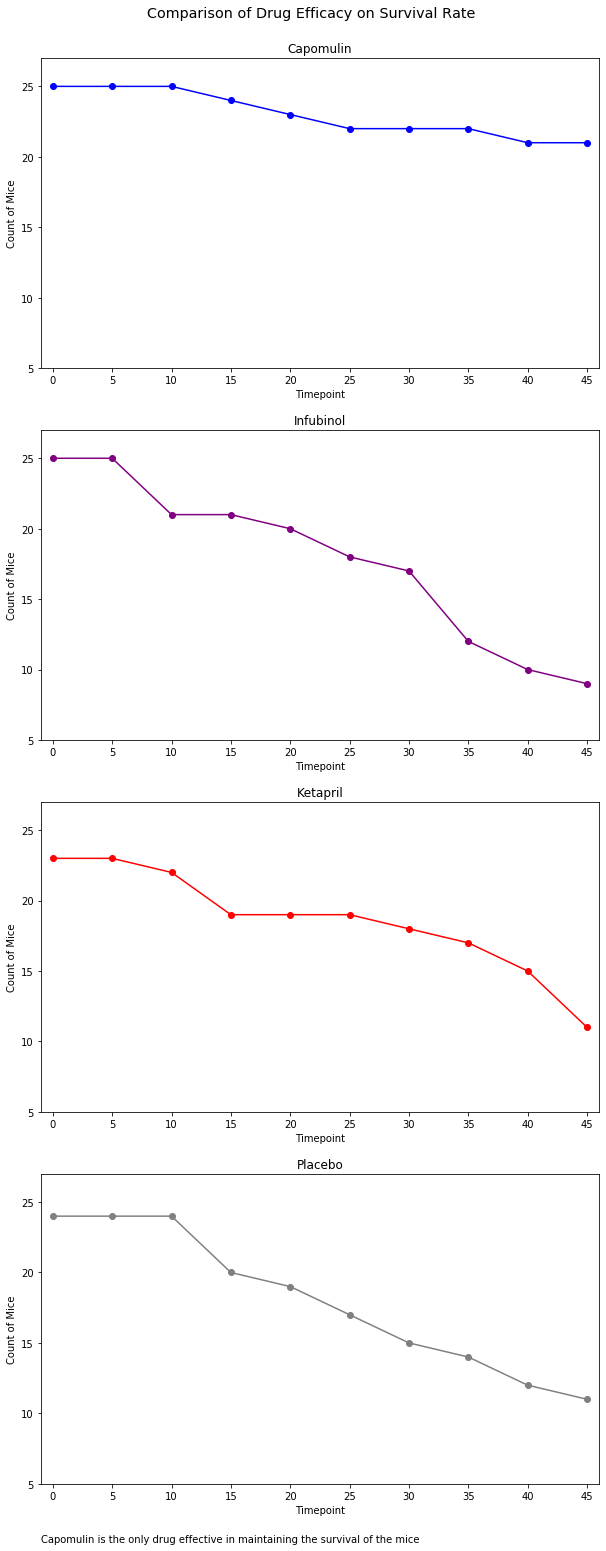

In [47]:
# Generate the Plot (Accounting for percentages)

# Save the Figure

# Show the Figure

# Generate the Plot (with Error Bars)
# reusing variable names
fig, (p1,p2,p3,p4) = plt.subplots(4, sharey=True,figsize=(10,24))
x_ticks = mouse_counts_rf.index
# p1.set_xlim(min(x_ticks)*0.95, max(x_ticks)*1.05)
# p1.set_xticks(x_ticks)
p1.set_ylim(5,27)
p1.set_yticks(np.arange(5,26,5))

counter = 0
for p in (p1,p2,p3,p4):
    # get the drug name from the list of columns for easy reference
    drug = mouse_counts_rf.columns[counter]
    p.plot(x_ticks, mouse_counts_rf[drug], c=colors[drug], marker="o",label=drug)
    p.title.set_text(drug)
    p.set_xticks(x_ticks)
    p.set_xlim(min(x_ticks)-1, max(x_ticks)+1)
    p.set_xlabel("Timepoint")
    p.set_ylabel("Count of Mice")
    counter += 1
    
fig.suptitle("Comparison of Drug Efficacy on Survival Rate", fontsize="x-large")
fig.subplots_adjust(top=.95)
plt.annotate('Capomulin is the only drug effective in maintaining the survival of the mice', 
             (0,0), (0, -50), xycoords='axes fraction', textcoords='offset points', va='top')

# Save the Figure
fig.savefig("../Images/Comparison of Drug Efficacy on Survival Rate.png")
# Show the Figure
plt.show()

![Metastatic Spread During Treatment](../Images/survival.png)

## Summary Bar Graph

In [ ]:
# Calculate the percent changes for each drug

# Display the data to confirm


Drug
Capomulin   -19.475303
Ceftamin     42.516492
Infubinol    46.123472
Ketapril     57.028795
Naftisol     53.923347
Placebo      51.297960
Propriva     47.241175
Ramicane    -22.320900
Stelasyn     52.085134
Zoniferol    46.579751
dtype: float64

In [ ]:
# Store all Relevant Percent Changes into a Tuple


# Splice the data between passing and failing drugs


# Orient widths. Add labels, tick marks, etc. 


# Use functions to label the percentages of changes


# Call functions to implement the function calls


# Save the Figure


# Show the Figure
fig.show()

![Metastatic Spread During Treatment](../Images/change.png)